In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    # compute and fill each NaN with the columns mean
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df.shape[0] - df.dropna().shape[0])
#     print(df[df.columns[df.isnull().any()]].columns)
    print(df.isnull().any())
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()) * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy()) * num_docks
    y_gold = data["bikes"].to_numpy() * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


## This code is added

In [3]:
# Adding all files into one DataFrame
df = []
for path in Path('./Train/Train').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
#     show_nans(tmp)
#     replace_nan(tmp)
#     tmp = tmp.dropna(axis='rows')
    df.append(tmp)

df = pd.concat(df, ignore_index=True)

columns = df.columns

nancount = pd.DataFrame(index = columns)
counts = []

for c in columns:

    counts.append(df[c].shape[0] - df[c].dropna().shape[0])
    
nancount["counts"] = counts
pd.set_option('display.max_rows', 23)
counts

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 75,
 75,
 375,
 75,
 75,
 75,
 75,
 300,
 12825,
 12600,
 12825,
 12600,
 75]

In [4]:
def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    # del df["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def vectorise_dataframe(dataframe):
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    del dataframe["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    #del dataframe["day"]
    #del dataframe["hour"]
    del dataframe["weekhour"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    #default_columns.remove('weekday')
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    #dataframe = pd.get_dummies(dataframe, columns=['weekday'])
    
    #default_columns = ["isOff", "weekday_Sunday", "weekday_Monday", "weekday_Tuesday", "weekday_Wednesday", 
                      #"weekday_Thursday", "weekday_Friday", "weekday_Saturday"] + default_columns
    
    default_columns = ["isOff"] + default_columns
    del dataframe["weekday"]
    default_columns.remove('weekday')
    print(default_columns)
    
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

# Adding all files into one DataFrame
df = []
for path in Path('./Train/Train').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
    # show_nans(tmp)
    #replace_nan(tmp)
    tmp = tmp.dropna(axis='rows')
    df.append(tmp)

df = pd.concat(df, ignore_index=True)

train, val = train_test_split(df, test_size=0.2)

train, train_docks = vectorise_dataframe(train)
val, val_docks = vectorise_dataframe(val)


# comment next line if not dropping NaNs



scaler = StandardScaler()
train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
val[val.columns[:-1]] = scaler.fit_transform(val[val.columns[:-1]])

print(df.columns)

['isOff', 'numDocks', 'day', 'hour', 'isHoliday', 'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades', 'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes']
Index(['isOff', 'numDocks', 'day', 'hour', 'isHoliday', 'windMaxSpeed.m.s',
       'windMeanSpeed.m.s', 'windDirection.grades', 'temperature.C',
       'relHumidity.HR', 'airPressure.mb', 'bikes_3h_ago',
       'full_profile_3h_diff_bikes', 'full_profile_bikes',
       'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes'],
      dtype='object')
['bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'bikes']
['isOff', 'numDocks', 'day', 'hour', 'isHoliday', 'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades', 'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'bikes_3h_ago', 'full_profile_3h_diff_bikes',

/var/folders/lx/p5f6tjxn78d7x0yr11l1pm_h0000gn/T/ipykernel_94334/1752323392.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()


(array([15077.,  9412.,  7218.,  5759.,  2925.,  1366.,   480.,   210.,
           50.,   103.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

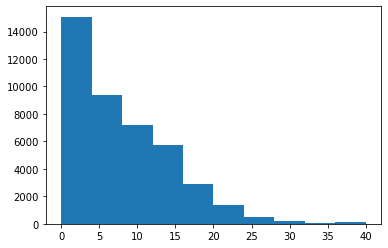

In [5]:
import matplotlib.pyplot as plt

plt.hist(df["bikes"])

In [6]:
forest = RandomForestRegressor(n_estimators=500, n_jobs=6)
print("initialised")
forest.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

importances = forest.feature_importances_
imp_indixes = np.argsort(importances)[::-1]
feature_order = train.columns[:-1][imp_indixes]
importances = importances[imp_indixes]

imp_df = pd.DataFrame(data = importances, index = feature_order, columns=["relative_importance"])

print(score_abs_error(forest, val, val_docks))

print(imp_df)

initialised
2.4220586326370737
                             relative_importance
bikes_3h_ago                            0.498703
short_profile_3h_diff_bikes             0.078753
full_profile_3h_diff_bikes              0.078478
short_profile_bikes                     0.070801
full_profile_bikes                      0.066675
airPressure.mb                          0.034966
hour                                    0.033730
temperature.C                           0.030562
relHumidity.HR                          0.027663
day                                     0.026147
windMaxSpeed.m.s                        0.018247
windDirection.grades                    0.016802
windMeanSpeed.m.s                       0.012452
isOff                                   0.006021


In [7]:
# plot_features = feature_order[:5].to_list()
# plot_features.append("bikes")
# print(plot_features)

# g = sns.PairGrid(df[plot_features], diag_sharey=False, corner=True)
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)


In [8]:


# lowest_ranked_10 = feature_order[-5:]
# for feature in lowest_ranked_10:
#     del df[feature]
# print(imp_df)





In [9]:



# columns = list(df.columns[-6:])
# print(columns)
# for c in columns:
#     train[c] = train[c].to_numpy() / train["numDocks"].to_numpy()
#     val[c] = val[c].to_numpy() / val["numDocks"].to_numpy()


# train_docks = train["numDocks"]
# val_docks = train["numDocks"]
# del train["numDocks"]
# del val["numDocks"]

val

# See all Rows/Cols

#pd.set_option('display.max_rows', 23)

,isOff,day,hour,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
7156,-0.297089,0.344490,-0.088302,-0.042868,-0.001605,-0.180257,0.758189,-2.011698,1.234214,-0.920062,3.045439,1.723037,3.045439,1.723037,0.950000
38337,-0.297089,0.053328,-1.684681,-1.148405,-1.030298,0.618392,-0.428625,1.453709,1.482592,-1.023771,0.768249,1.431007,0.768249,1.431007,0.066667
42323,-0.297089,0.053328,-0.233427,-0.418979,-0.687400,-0.180257,-1.065452,0.396466,1.322920,-0.865158,3.424971,1.822671,3.424971,1.822671,0.764706
8707,-0.297089,-0.528996,-1.394430,1.415985,1.391418,0.352176,0.034522,0.102788,-0.752816,-1.231189,-0.081903,-1.372479,-0.081903,-1.372479,0.000000
23819,-0.297089,1.509139,-0.088302,-0.783692,-0.687400,-0.180257,-0.428625,0.748880,1.092283,-0.453373,1.261640,-0.145954,1.261640,-0.145954,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,-0.297089,0.344490,-0.668803,2.703879,3.105907,-0.446473,0.237149,-1.189398,0.914870,-1.231189,0.844155,-0.730013,0.844155,-0.730013,0.100000
33199,-0.297089,-0.237834,1.508078,-0.601336,-0.344503,-1.245121,-0.081265,1.394973,0.968094,-0.453373,-0.560113,0.379700,-0.560113,0.379700,0.125000
13616,-0.297089,1.654720,-0.523678,-1.148405,-1.030298,-0.180257,-1.007558,1.101295,1.216472,-1.023771,0.616436,-0.029142,0.616436,-0.029142,0.333333
6715,-0.297089,1.072396,1.072702,0.686558,1.391418,-1.245121,-0.312838,1.218766,0.648750,0.635570,0.414019,-0.282234,0.414019,-0.282234,0.733333


In [10]:
df

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,...,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,206,39.472030,-0.370965,24,1.412730e+09,2014,10,8,3,Wednesday,...,21.5,59.0,1011.5,0.0,0.0,0.00,0.00,0.00,0.00,0.0
1,206,39.472030,-0.370965,24,1.412734e+09,2014,10,8,4,Wednesday,...,20.8,62.0,1011.1,0.0,0.0,0.00,0.00,0.00,0.00,0.0
2,206,39.472030,-0.370965,24,1.412737e+09,2014,10,8,5,Wednesday,...,19.8,67.0,1010.9,0.0,0.0,0.00,0.00,0.00,0.00,0.0
3,206,39.472030,-0.370965,24,1.412741e+09,2014,10,8,6,Wednesday,...,19.7,66.0,1010.8,0.0,0.0,1.00,1.00,1.00,1.00,1.0
4,206,39.472030,-0.370965,24,1.412744e+09,2014,10,8,7,Wednesday,...,19.6,67.0,1011.1,0.0,0.0,2.00,2.00,2.00,2.00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42595,208,39.469056,-0.375728,34,1.414778e+09,2014,10,31,19,Friday,...,20.2,80.0,1023.5,0.0,12.0,0.25,10.00,0.25,10.00,6.0
42596,208,39.469056,-0.375728,34,1.414782e+09,2014,10,31,20,Friday,...,20.2,82.0,1023.9,0.0,9.0,-2.25,6.50,-2.25,6.50,7.0
42597,208,39.469056,-0.375728,34,1.414786e+09,2014,10,31,21,Friday,...,20.0,83.0,1024.0,0.0,6.0,-1.75,6.00,-1.75,6.00,6.0
42598,208,39.469056,-0.375728,34,1.414789e+09,2014,10,31,22,Friday,...,19.3,84.0,1024.4,0.0,6.0,-6.75,3.25,-6.75,3.25,5.0


# Random elimination parameter tuning
## Random forest regressor

This cell uses `HalvingRandomSearchCV` to find near-optimal parameters for a random forest regressor. It takes a while to run with these parameters.

In [11]:
# forest_boost = GradientBoostingRegressor(n_estimators=n_est, loss='squared_error', learning_rate=0.2, max_depth=2, verbose=1)
#  forest_boost = SVR()
#searched_boost = RandomForestRegressor()#n_estimators = 50)#, verbose=1)




# param_distributions = {"max_depth":  [2,3,4],   #, 5, 6, None],
#                        "min_samples_split": np.around(np.linspace(2,30,10)).astype(np.int32),
#                        "learning_rate": np.linspace(0.0001,1,20),
#                        "n_estimators": np.linspace(5, 5000, 50).astype(np.int32)
#                       }


# search = HalvingRandomSearchCV(searched_boost, param_distributions,
#                                resource='n_estimators', max_resources = 5000, min_resources = 100,
#                                factor = 2 ,cv = 3,    # n_candidates =  25
#                                random_state=0, verbose=1, n_jobs=6).fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# n_meta_iterations = 25

# best_params = {"max_depth":7, "min_samples_split":15, "n_estimators":500}

# results = []

# for i in range(1, n_meta_iterations + 1):
#     print(f'\n---------------------------------\nIteration {i}\n')
#     fac = 0.75 / (i)
    
#     param_distributions = {}#"criterion": ["squared_error", "absolute_error", "poisson"]}
    
#     for param in list(best_params.keys()):
        
        
#         param_low = int(best_params[param]*(1-fac))
#         if param_low <= 1:
#             param_low  = param_low + 1
            
#         param_high = int(best_params[param]*(1+fac))
#         if param_high <= param_low:
#             param_high  = param_high + 1
        
#         print(f'low/high {param} limits {param_low, param_high}')
#         param_distributions[param] = randint(param_low, param_high)
        
#     #print(param_distributions)
    
# #     param_distributions = {"max_depth":  randint(2,5),   #, 5, 6, None],
# #                            "min_samples_split": randint(2,20),
# #                            #"learning_rate": np.linspace(0.0001,1,20),
# #                            #"n_estimators": np.linspace(5, 5000, 50).astype(np.int32)
# #                           }

#     search = RandomizedSearchCV(searched_boost, param_distributions, cv = 3, n_iter = 5,   # n_candidates =  25
#                                     verbose=1, n_jobs=5)
    
#     search.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())
    
#     results.append(search.cv_results_)
    
#     print(search.cv_results_)

#     best_params = search.best_params_
    
#     searched_boost = RandomForestRegressor()#n_estimators = 50)#, verbose=1)

In [12]:
# from time import time
# from sklearn.experimental import enable_halving_search_cv  # noqa
# from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
# from scipy.stats import randint, uniform

# searched_boost = GradientBoostingRegressor()

# param_distributions = {"max_depth":  randint(2, 10),   #, 5, 6, None],
#                        "min_samples_split": randint(2, 30),
#                        "learning_rate": uniform(),
#                        "n_estimators": randint(10, 5000)
#                       }

# search = RandomizedSearchCV(searched_boost, param_distributions, cv = 3, n_iter = 50,   # n_candidates =  25
#                                 verbose=2, n_jobs=5)

# search.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())


# print(search.best_params_)

In [13]:
# import seaborn as sns
# res = pd.DataFrame(search.cv_results_)

# print(res[res["mean_test_score"] >= 0.675][["param_learning_rate", "mean_test_score", "param_n_estimators", "param_min_samples_split", "param_max_depth"]])

# feats = ["param_learning_rate", "mean_test_score", "param_n_estimators", "param_min_samples_split", "param_max_depth"]

# print(search.best_params_)
# plt.figure(figsize=(14,12))
# im = plt.scatter(res["param_learning_rate"], res["mean_test_score"], c = res["param_n_estimators"], s = 25*res["param_min_samples_split"].to_numpy().astype(np.float32), linewidth = 0.5, edgecolor = '0')
# plt.ylabel("Score")
# plt.xlabel("Learning rate")
# plt.colorbar(im)
# plt.show()

In [14]:
# sns.pairplot(res, vars = feats, hue = "mean_test_score")

In [15]:
from time import time
start = time()
print("initialised")
#forest_boost = GradientBoostingRegressor(**search.best_params_, verbose = 1)
#forest_boost = GradientBoostingRegressor(**search.best_params_)
#forest_boost = RandomForestRegressor(n_estimators= 2500, max_depth= 3,  verbose = 1)
forest_boost = GradientBoostingRegressor(n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error")#SVR(kernel = 'poly', degree = 3, epsilon = 0.01)
#
forest_boost.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())
print(f'fitted in {time() - start}s')

initialised
      Iter       Train Loss   Remaining Time 
         1           0.2711            1.31m
         2           0.2701            1.31m
         3           0.2692            1.28m
         4           0.2683            1.27m
         5           0.2673            1.26m
         6           0.2664            1.25m
         7           0.2655            1.25m
         8           0.2646            1.24m
         9           0.2636            1.24m
        10           0.2627            1.23m
        20           0.2539            1.22m
        30           0.2456            1.20m
        40           0.2378            1.19m
        50           0.2304            1.18m
        60           0.2235            1.16m
        70           0.2171            1.15m
        80           0.2110            1.14m
        90           0.2054            1.13m
       100           0.2001            1.11m
       200           0.1623           59.43s
       300           0.1431           51.9

In [16]:
print(score_abs_error(forest_boost, val, val_docks))
print(score_abs_error(forest_boost, val, val_docks, round_ = True))

2.392006412662363
2.373943661971831


## Score tracking

 - un-vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.33, rounding integers 2.31
 
 - vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, 2.43, 2.42
 
 - un-vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, , loss="absolute_error",  2.4, 2.38

In [17]:


# results = pd.DataFrame(search.cv_results_)
# results["params_str"] = results.params.apply(str)
# params = search.param_distributions
# # results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
# learning_rates = params["learning_rate"]
# mean_scores = results.pivot(
#     index="iter", columns="params_str", values="mean_test_score"
# )

# fig, ax = plt.subplots(figsize=(16,12))
# mean_scores.plot(legend=False, alpha=0.6, ax = ax, linewidth=8)

# labels = [
#     f"iter={i}\nn_samples={search.n_resources_[i]} \nn_candidates={search.n_candidates_[i]}"# \nn_estimators={params["n_estimators"][i]} "
#     for i in range(search.n_iterations_)
# ]

# ax.set_xticks(range(search.n_iterations_))
# ax.set_xticklabels(labels, rotation=45, multialignment="left")
# ax.set_title("Scores of candidates over iterations")
# ax.set_ylabel("mean test score", fontsize=15)
# ax.set_xlabel("iterations", fontsize=15)
# plt.tight_layout()
# plt.show()


/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


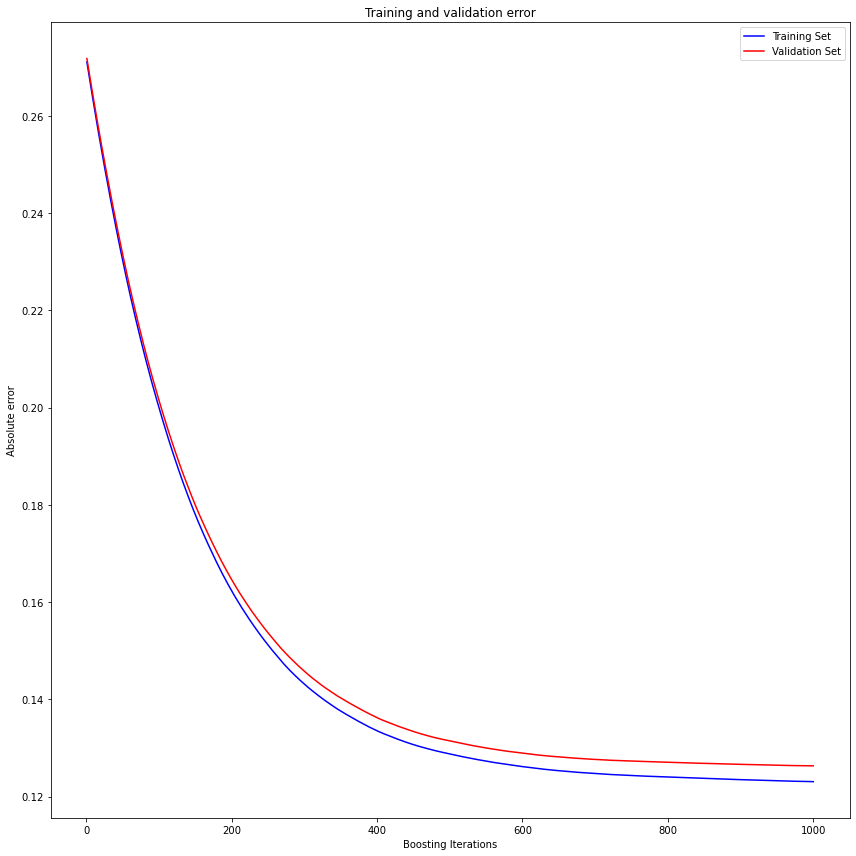

In [18]:

n_est = 1000

import matplotlib.pyplot as plt
test_score = np.zeros((n_est,), dtype=np.float64)

y_test = val["bikes"]
#y_pred = reasonable_predictions(forest_boost, val.iloc[:, :-1])

for i, y_pred in enumerate(forest_boost.staged_predict(val.iloc[:,:-1])):
    test_score[i] = forest_boost.loss_(y_test, y_pred)


fig = plt.figure(figsize=(12
                          , 12))
plt.subplot(1, 1, 1)
plt.title("Training and validation error")
plt.plot(
    np.arange(n_est) + 1,
    forest_boost.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(n_est) + 1, test_score, "r-", label="Validation Set"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Absolute error")
#plt.yscale('log')
fig.tight_layout()
plt.show()

/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


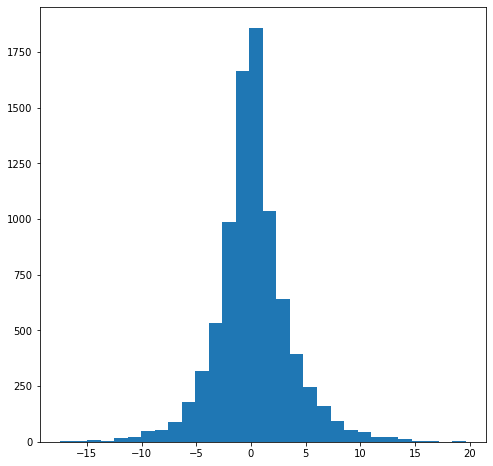

In [19]:
plt.figure(figsize=(8,8))
plt.hist(y_test*val_docks - forest_boost.predict(val.iloc[:,:-1])*val_docks, bins = 30)
plt.show()

In [20]:
test = pd.read_csv('test.csv')

ids = test["Id"]

# del test["Id"]
# del test["month"]
# del test["year"]

# convert_weekdays(test)
# # test[test.columns] = scaler.fit_transform(test[test.columns])

# for feature in lowest_ranked_10:
#     del test[feature]
    
# print(test.columns)  
# print(train.columns)

test, test_docks = generate_dataframe(test)

#y_pred = forest_boost.predict(test)
y_pred = reasonable_predictions(forest_boost, test) * test_docks

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

print(sub_df.head())

sub_df.to_csv("trial.csv")

Index(['isOff', 'Id', 'numDocks', 'timestamp', 'day', 'hour', 'weekday',
       'weekhour', 'isHoliday', 'windMaxSpeed.m.s', 'windMeanSpeed.m.s',
       'windDirection.grades', 'temperature.C', 'relHumidity.HR',
       'airPressure.mb', 'bikes_3h_ago', 'full_profile_3h_diff_bikes',
       'full_profile_bikes', 'short_profile_3h_diff_bikes',
       'short_profile_bikes'],
      dtype='object')
['bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes', 'short_profile_3h_diff_bikes', 'short_profile_bikes']


ValueError: X has 18 features, but GradientBoostingRegressor is expecting 14 features as input.